# 2.8 Model Context Protocol(MCP with Langgraph)
- LangGraph와 MCP(Model Context Protocol)를 통합하여 강력한 AI 에이전트를 구축하는 방법을 배웁니다.
- MCP는 AI 애플리케이션에서 도구(Tool)와 컨텍스트를 표준화된 방식으로 제공하는 오픈 프로토콜입니다.
> 참고 문서: [Model Context Protocol 공식 문서](https://modelcontextprotocol.io/introduction)

### MCP(Model Context Protocol)란?

- MCP는 애플리케이션이 언어 모델에 도구와 컨텍스트를 제공하는 방법을 표준화한 오픈 프로토콜입니다. 이 프로토콜을 사용하면 다양한 서비스와 도구를 일관된 방식으로 LLM에 연결할 수 있습니다.
- MCP를 사용하기 위해 필요한 패키지를 설치합니다. `langchain-mcp-adapters` 패키지는 LangChain 에이전트가 MCP 서버에 정의된 도구를 사용할 수 있도록 해줍니다.

In [1]:
%pip install -q langchain-mcp-adapters "mcp[cli]" fastmcp

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import List, Dict, Any

from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv()

True

## 기본 MCP 서버 생성

MCP 서버는 도구를 제공하는 독립적인 프로세스입니다. FastMCP를 사용하면 Python으로 간단하게 MCP 서버를 만들 수 있습니다. 이 튜토리얼에서는 미리 준비된 MCP 서버들을 사용합니다.

### 지원하는 전송 방식

- **stdio**: 클라이언트가 서버를 서브프로세스로 실행하고 표준 입출력을 통해 통신합니다. 로컬 개발에 적합합니다.
- **streamable_http**: 서버가 독립적인 프로세스로 실행되어 HTTP 요청을 처리합니다. 원격 연결에 적합합니다.

### 제공되는 MCP 서버

이 튜토리얼에서 사용하는 MCP 서버 파일들은 `mcp_server/` 디렉토리에 위치해 있습니다:

| 파일명 | 설명 | 전송 방식 |
|--------|------|-----------|
| `mcp_server_add.py` | 두 수를 덧셈한 값을 제공하는 로컬 서버 | stdio |
| `mcp_server_multiple.py` | 두 수를 곱셈한 값을 제공하는 원격 서버 | HTTP |
| `mcp_server_rag.py` | 청년월세지원 관련 문서 검색 기능을 제공하는 RAG 서버 | stdio |

각 서버는 `FastMCP`를 사용하여 구현되어 있으며, 도구(Tool)를 정의하고 클라이언트 요청에 응답합니다.

## MultiServerMCPClient 설정

`MultiServerMCPClient`는 여러 MCP 서버를 동시에 관리하고 연결할 수 있는 클라이언트입니다. 각 서버에서 제공하는 도구들을 통합하여 하나의 도구 목록으로 사용할 수 있습니다.
아래 코드는 MCP 클라이언트를 설정하고 서버에서 도구를 가져오는 헬퍼 함수를 정의합니다.

In [4]:
# MCP 클라이언트: 여러 MCP 서버에 연결하여 도구를 가져옵니다
from langchain_mcp_adapters.client import MultiServerMCPClient

async def setup_mcp_client(server_configs: dict):
    # MCP 클라이언트 생성
    client = MultiServerMCPClient(server_configs)

    # 서버에서 도구 가져오기
    tools = await client.get_tools()

    # 로드된 도구 목록 출력
    print(f"[MCP] {len(tools)}개의 도구가 로드되었습니다:")
    for tool in tools:
        print(f"  - {tool.name}")

    return client, tools

In [5]:
# 날씨 서버 구성 정의 (stdio 전송 방식)
server_configs = {
    "add": {
        "command": "python", 
        "args": ["./mcp_server/mcp_server_add.py"],
        "transport": "stdio",  # 표준 입출력을 통한 통신
    }
}

# MCP 클라이언트 생성 및 도구 로드
client, tools = await setup_mcp_client(server_configs=server_configs)

[MCP] 1개의 도구가 로드되었습니다:
  - add_two_numbers


In [6]:
# LLM 설정
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# React Agent 생성: MCP 도구를 사용하는 ReAct 패턴 에이전트
agent = create_agent(
    llm,
    tools,
    checkpointer=InMemorySaver()  # 대화 상태를 메모리에 저장
)

In [15]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

query = '3과 5를 더한 값은?'
async for chunk in agent.astream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3과 5를 더한 값은?
================================== Ai Message ==================================
Tool Calls:
  add_two_numbers (call_fjko5aZYBn9F5EhRHP3VBjYV)
 Call ID: call_fjko5aZYBn9F5EhRHP3VBjYV
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: add_two_numbers

[{'type': 'text', 'text': '8', 'id': 'lc_7b8587c5-f801-4baa-8d51-8abb2fff6675'}]
================================== Ai Message ==================================

3과 5를 더한 값은 8입니다.


### HTTP 전송 방식 사용

원격 서버나 HTTP 엔드포인트를 사용하는 경우 `streamable_http` 전송 방식을 사용합니다. 이 방식은 서버가 별도의 프로세스로 실행 중이어야 합니다.

**사전 준비**: 아래 코드를 실행하기 전에 별도의 터미널에서 Remote MCP 서버를 먼저 구동해야 합니다.

```bash
python server/mcp_server_remote.py
```

In [16]:
# HTTP 기반 MCP 서버 설정
http_server_config = {
    "multiple": {
        "url": "http://127.0.0.1:8002/mcp",  # HTTP 엔드포인트 URL
        "transport": "streamable_http",  # HTTP 스트리밍 전송 방식
    },
}

# MCP 클라이언트 생성 및 HTTP 서버 도구 로드
client, http_tools = await setup_mcp_client(server_configs=http_server_config)

[MCP] 1개의 도구가 로드되었습니다:
  - multiple


In [17]:
# LLM 설정 (경량 모델 사용)
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# HTTP 도구를 사용하는 React Agent 생성
agent = create_agent(
    llm, 
    http_tools, 
    checkpointer=InMemorySaver()
)

In [18]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

query = '3과 5를 곱한 값은?'
async for chunk in agent.astream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3과 5를 곱한 값은?
================================== Ai Message ==================================
Tool Calls:
  multiple (call_r6i4FZWOPnH8gUaA7vMXdqWR)
 Call ID: call_r6i4FZWOPnH8gUaA7vMXdqWR
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: multiple

[{'type': 'text', 'text': '15', 'id': 'lc_968d78e8-2208-4fb1-b19a-09788b9bf903'}]
================================== Ai Message ==================================

3과 5를 곱한 값은 15입니다.


## ToolNode와 MCP 통합

`ToolNode`를 사용하면 LangGraph에서 더 세밀한 제어가 가능한 커스텀 워크플로우를 만들 수 있습니다. React Agent와 달리, 그래프의 각 노드를 직접 정의하고 연결할 수 있어 복잡한 로직을 구현하기에 적합합니다.

아래 코드는 MCP 도구와 추가 도구를 결합한 커스텀 워크플로우를 생성합니다.

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing import Annotated, List, Dict, Any
from langchain_openai import ChatOpenAI
from typing import TypedDict
from langchain_community.tools import TavilySearchResults


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    context: Dict[str, Any]


async def create_mcp_workflow(server_configs: dict):
    # MCP 클라이언트 생성 및 도구 로드
    client, tools = await setup_mcp_client(server_configs=server_configs)

    # Tavily 웹 검색 도구 추가
    tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    )
    tools.append(tavily_search_tool)

    # LLM 설정 및 도구 바인딩
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    llm_with_tools = llm.bind_tools(tools)

    # 워크플로우 그래프 생성
    workflow = StateGraph(AgentState)

    async def agent_node(state: AgentState):
        response = await llm_with_tools.ainvoke(state["messages"])
        return {"messages": [response]}

    # ToolNode 생성: 도구 호출을 처리합니다
    tool_node = ToolNode(tools)

    # 그래프에 노드 추가
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", tool_node)

    # 엣지 정의: 시작 -> 에이전트
    workflow.add_edge(START, "agent")
    
    # 조건부 엣지: 에이전트 -> (도구 or 종료)
    # tools_condition은 도구 호출이 필요하면 "tools"로, 아니면 END로 라우팅합니다
    workflow.add_conditional_edges("agent", tools_condition)
    
    # 도구 -> 에이전트 (도구 실행 후 다시 에이전트로)
    workflow.add_edge("tools", "agent")

    # 그래프 컴파일
    app = workflow.compile(checkpointer=InMemorySaver())

    # 그래프 시각화
    display(Image(app.get_graph().draw_mermaid_png()))

    return app

In [22]:
# MCP 서버 구성 정의
server_configs = {
    "weather": {
        "command": "python",
        "args": ["./mcp_server/mcp_server_rag.py"],
        "transport": "stdio",
    },
    "multiple": {
        "url": "http://127.0.0.1:8002/mcp",
        "transport": "streamable_http",
    },
    "add": {
        "command": "python",
        "args": ["./mcp_server/mcp_server_add.py"],
        "transport": "stdio",
    },
}

[MCP] 3개의 도구가 로드되었습니다:
  - retrieve
  - multiple
  - add_two_numbers


/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_23298/2097924142.py:22: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


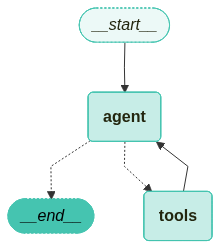

In [23]:
# MCP 워크플로우 생성 및 그래프 시각화
mcp_app = await create_mcp_workflow(server_configs)

In [25]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

query = '청년월세지원 신청기한은 언제야?'
async for chunk in mcp_app.astream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

청년월세지원 신청기한은 언제야?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_5Sj5GPzAzZuuB0KN9M7T45nG)
 Call ID: call_5Sj5GPzAzZuuB0KN9M7T45nG
  Args:
    query: 청년월세지원 신청기한
================================= Tool Message =================================
Name: retrieve

[{'type': 'text', 'text': "※ 중지 사유가 발생한 다음 달부터 즉시 중지됨\n\n\n주소지 및 임대차계약 사항이 변경될 경우 반드시 ‘변경 신청’ 등록\n\n※ 임대차계약이 변경되어 변경신고할 경우, 변경 사유가 발생할 원인 등 근거대로 지급하고 새로운 임대차계약 내용은 익월부터 적용\n\n9. 기타 유의사항\n\n\n사업신청, 접수, 이의신청, 변경 및 중지신청은 모두 서울주거포털에서 온라인으로 처리되며 등록한 정보가 부정확하거나 사실과 다른 경우 불이익을 받을 수 있으므로 해당 사항을 정확하게 등록하여야 함.\n\n\n신청 자격 확인 또는 보완이 필요한 경우 별도의 자료를 요청할 수 있음.\n\n\n사업 신청 내용이 자격 요건에 적합하지 않거나 경우 또는 착오 및 부정하게 신청할 경우 월세 지원 취소 및 환수 조치됩니다.\n\n\n제출서는 반환하지 않으며, 기재내용 및 제출서류가 사실과 다른 경우 지원 대상자로 선정되더라도 취소됩니다.\n\n\n신청접수 관련 문의는 서울주택도시공사 청년원세지원센터(☎1833-2030), 기타 문의는 서울시 다산콜센터(☎120)에 문의하시기 바랍니다.\n\n\n◆ 전화 문의 폭주로 인한 상담 지

## Part 6: 외부 MCP 서버에서 3rd Party 도구 사용하기

[Smithery AI](https://smithery.ai/)
[mcpserverhub](https://mcpserverhub.com/servers)

### Context7 MCP 서버

이 예제에서는 Smithery AI에서 제공하는 `context7-mcp` 서버를 사용합니다. 이 서버는 최신 프로그래밍 언어 및 프레임워크 문서를 검색하고 제공하는 기능을 가지고 있습니다.

아래 코드는 Context7 MCP 서버를 포함한 다중 서버 구성을 설정합니다.

In [28]:
# 다중 MCP 서버 구성 (로컬 + HTTP + Smithery AI)
server_configs = {
    "weather": {
        "command": "python",
        "args": ["./mcp_server/mcp_server_rag.py"],
        "transport": "stdio",
    },
    "multiple": {
        "url": "http://127.0.0.1:8002/mcp",
        "transport": "streamable_http",
    },
    "add": {
        "command": "python",
        "args": ["./mcp_server/mcp_server_add.py"],
        "transport": "stdio",
    },
    
    # Smithery AI의 Context7 MCP 서버: 최신 문서 검색
    "context7": {
    "type": "remote",
    "url": "https://mcp.context7.com/mcp",
    "transport": "streamable_http"
    }
}

# 다중 서버를 사용하는 MCP 워크플로우 생성
mcp_app = await create_mcp_workflow(server_configs)

TypeError: _create_streamable_http_session() got an unexpected keyword argument 'type'

In [ ]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'thread1'
    }
}

query = '청년월세지원 신청기한은 언제야?'
async for chunk in mcp_app.astream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()